In [2]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


In [3]:
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Keras modules

In [6]:
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D, Input,Add

## Cargo datos

In [7]:
from keras.datasets import cifar10
((x, y), (x_test,y_test)) = cifar10.load_data()

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1)

## Paso a float

In [9]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [10]:
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_valid)

## Red neuronal: CNN tipo RESNET

In [16]:
net_input = Input(shape=(32,32,3))

def res_block_first(input_layer,filters=16):
    
    #Primera capa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(aux_net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    
    #Shortcut
    net=Add()([aux_net,net])
    
    net=Activation("relu")(net)
    net=MaxPooling2D()(net)
    
    return net

def res_block(input_layer,filters=16):
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    
    #Shortcut
    net=Add()([input_layer,net])
    net=Activation("relu")(net)
    
    return net

def res_block_dec(input_layer,filters=32):
    
    input_layer=MaxPooling2D()(input_layer)
    net=Conv2D(filters=filters, kernel_size=(1, 1), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Add()([aux_net,net])
    net=Activation("relu")(net)
    
    return net

net=res_block_first(net_input,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)
net=res_block(net,filters=16)
net=res_block_dec(net,filters=32)
net=res_block(net,filters=32)
net=res_block(net,filters=32)
net=res_block(net,filters=32)
net=res_block_dec(net,filters=64)
net=res_block(net,filters=64)
net=res_block(net,filters=64)
net=res_block(net,filters=64)
net=res_block_dec(net,filters=128)
net=res_block(net,filters=128)
net=res_block(net,filters=128)
net=res_block(net,filters=128)

net = AveragePooling2D() (net)

net=Flatten()(net)

net=Dense(units=256, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=10, activation = 'softmax')(net)

model=Model(net_input,net)

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 32, 32, 16)   64          conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 32, 32, 16)   2320        batch_normalization_53[0][0]     
__________________________________________________________________________________________________
batch_norm

In [17]:
# Callbacks
checkpoint_file='checkpoint.mnist-cnn-tipo-RESNET.hdf5'
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_acc",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [18]:
x_train.shape

(45000, 32, 32, 3)

In [19]:
y_train_categorical.shape

(45000, 10)

In [20]:
batch_size = 64
epocs = 100

history = model.fit(x_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 35s 773us/step - loss: 1.6192 - acc: 0.4005 - val_loss: 1.8315 - val_acc: 0.4130

Epoch 00001: val_acc improved from -inf to 0.41300, saving model to checkpoint.mnist-cnn-tipo-RESNET.hdf5
Epoch 2/100
45000/45000 [==============================] - 25s 559us/step - loss: 1.1946 - acc: 0.5761 - val_loss: 1.2874 - val_acc: 0.5496

Epoch 00002: val_acc improved from 0.41300 to 0.54960, saving model to checkpoint.mnist-cnn-tipo-RESNET.hdf5
Epoch 3/100
45000/45000 [==============================] - 25s 558us/step - loss: 0.9906 - acc: 0.6530 - val_loss: 1.0689 - val_acc: 0.6338

Epoch 00003: val_acc improved from 0.54960 to 0.63380, saving model to checkpoint.mnist-cnn-tipo-RESNET.hdf5
Epoch 4/100
45000/45000 [==============================] - 25s 558us/step - loss: 0.8460 - acc: 0.7067 - val_loss: 0.9587 - val_acc: 0.6816

Epoch 00004: val_acc improved from 0.63380 to 0.68160, saving m

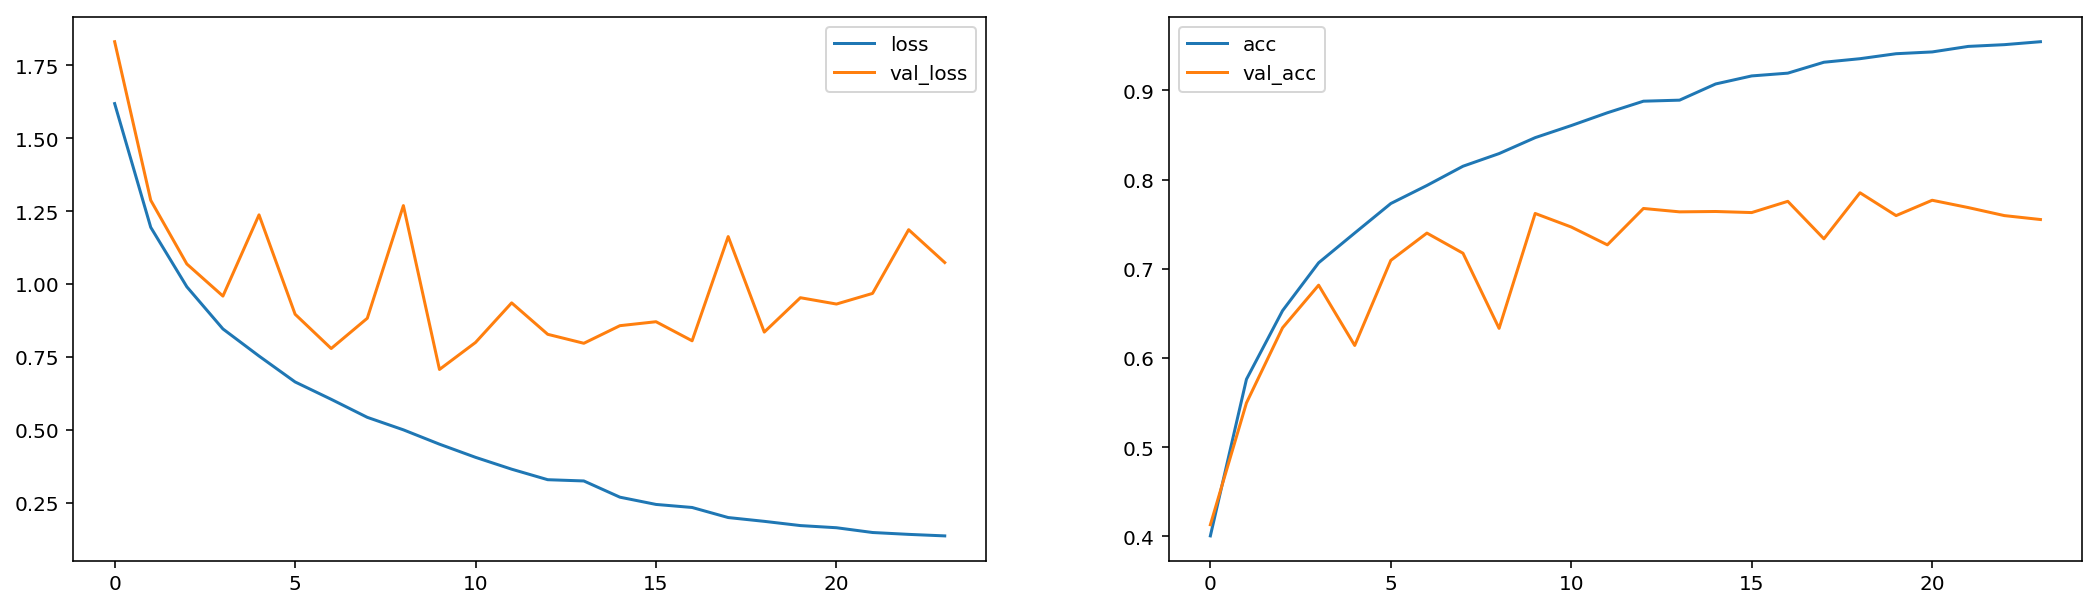

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['acc'], label="acc")
ax2.plot(history.history['val_acc'], label="val_acc")
ax2.legend()
plt.show();

In [46]:
model.load_weights('checkpoint.mnist-cnn.hdf5')